In [1]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import urllib.request
import random

# Data preparation

In [4]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [5]:
urllib.request.urlretrieve(url, filename="data-week-4.csv")
print("File downloaded successfully")

File downloaded successfully


In [6]:
df = pd.read_csv("data-week-4.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [8]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [9]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [10]:
numerical_columns = df.select_dtypes(include='number').columns.tolist()
numerical_columns.remove('converted')
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [11]:
for c in categorical_columns:
    df[c] = df[c].str.lower()
    df[c] = df[c].fillna('NA')

In [12]:
for c in numerical_columns:
    df[c] = df[c].fillna(0.0)

In [13]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [78]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [79]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

# Q1 - ROC AUC feature importance

### ROC curves

In [80]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [81]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [82]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

## ROC & AUC

In [85]:
tpr = tp / (tp + fn)
tpr

np.float64(0.9590643274853801)

In [86]:
fpr = fp / (fp + tn)
fpr

np.float64(0.6639344262295082)

In [87]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [88]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

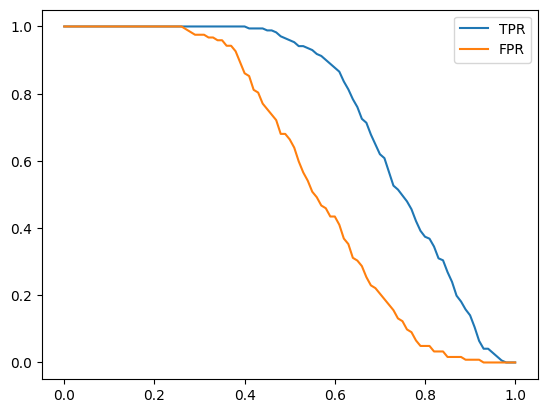

In [89]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [90]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [91]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [92]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

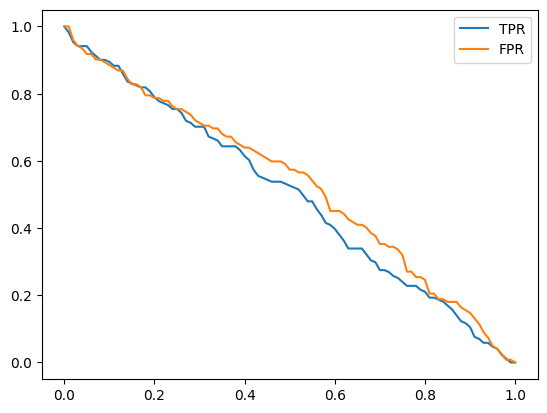

In [93]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [94]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(122), np.int64(171))

In [95]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [96]:
1 - y_val.mean()

np.float64(0.41638225255972694)

In [97]:
accuracy_score(y_ideal, y_ideal_pred >= 0.416)

1.0

In [98]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,171,122,0,0,1.000000,1.000000
10,0.1,171,92,0,30,1.000000,0.754098
20,0.2,171,63,0,59,1.000000,0.516393
30,0.3,171,34,0,88,1.000000,0.278689
40,0.4,171,5,0,117,1.000000,0.040984
50,0.5,147,0,24,122,0.859649,0.000000
60,0.6,117,0,54,122,0.684211,0.000000
70,0.7,88,0,83,122,0.514620,0.000000
80,0.8,59,0,112,122,0.345029,0.000000
90,0.9,30,0,141,122,0.175439,0.000000


In [99]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

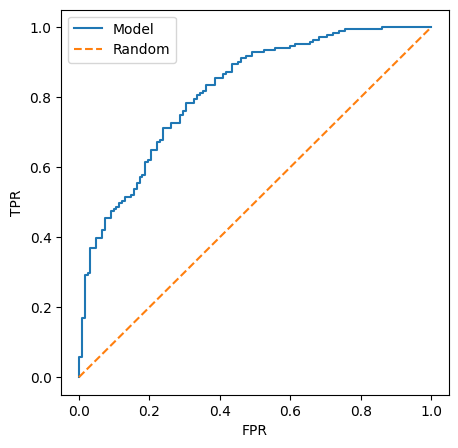

In [100]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [101]:
auc(fpr, tpr)

0.8171316268814112

In [102]:
auc(df_scores.fpr, df_scores.tpr)

0.8161969130476464

In [103]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999520659572428

In [104]:
roc_auc_score(y_val, y_pred)

0.8171316268814112

In [105]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [106]:
for col in numerical_columns:
    auc_score = roc_auc_score(y_train, df_train[col])
    
    # Check if we need to invert
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[col])
        print(f'{col}: {auc_score:.4f} (inverted)')
    else:
        print(f'{col}: {auc_score:.4f}')

number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145


# Q2 - Training the model

In [110]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [111]:
auc_score = roc_auc_score(y_val, y_pred)
print(f'AUC on validation set: {auc_score:.3f}')

AUC on validation set: 0.920


# Q3 - Precision and Recall

In [131]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [132]:
precisions = []
recalls = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

In [133]:
valid_indices = [(precisions[i] > 0.01 and recalls[i] > 0.01) for i in range(len(thresholds))]

valid_thresholds = thresholds[valid_indices]
valid_precisions = np.array(precisions)[valid_indices]
valid_recalls = np.array(recalls)[valid_indices]

# Find intersection among valid points
diff = np.abs(valid_precisions - valid_recalls)
intersection_idx = np.argmin(diff)
intersection_threshold = valid_thresholds[intersection_idx]

print(f'Precision and Recall intersect at threshold: {intersection_threshold:.2f}')
print(f'Precision at intersection: {valid_precisions[intersection_idx]:.3f}')
print(f'Recall at intersection: {valid_recalls[intersection_idx]:.3f}')

Precision and Recall intersect at threshold: 0.53
Precision at intersection: 0.872
Recall at intersection: 0.877


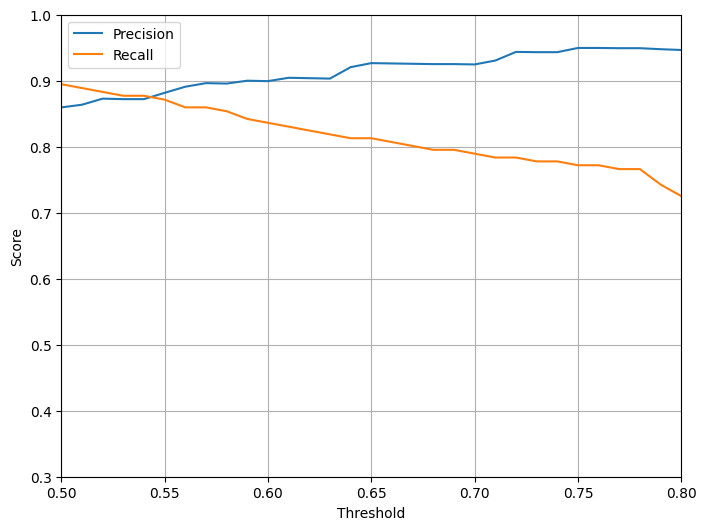

In [134]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xlim(0.5, 0.8)  # Zoom in on the intersection area
plt.ylim(0.3, 1.0)
plt.legend()
plt.grid(True)
plt.show()

# Q4 - F1 score

In [141]:
f1_scores = []
thresholds = np.linspace(0, 1, 101)
threshold_f1 = {}

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1_score = 2 * ((precision * recall) / (precision + recall))
    #f1_scores.append(f1_score)

    threshold_f1[t] = f1_score    
    
    #print(f"Threshold - {t} -> F1 score: {f1_score}")

C:\Users\LMazur\AppData\Local\Temp\ipykernel_21484\4078158673.py:21: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * ((precision * recall) / (precision + recall))


In [148]:
[k for k, v in threshold_f1.items() if v == max(threshold_f1.values())]

[np.float64(0.52)]

# Q5 - 5-Fold CV

In [165]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [170]:
dv, model = train(df_train, y_train)

In [171]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [172]:
y_pred = predict(df_val, dv, model)

In [176]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

C = 1.0
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1.0 0.822 +- 0.036


# Q6 - Hyperparameter Tuning

In [177]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [178]:
dv, model = train(df_train, y_train, C=1.0)

In [179]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [180]:
y_pred = predict(df_val, dv, model)

In [181]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.867 +- 0.029
C=0.01 0.831 +- 0.034
C=0.1 0.823 +- 0.035
C=0.5 0.822 +- 0.036
C=1 0.822 +- 0.036
C=5 0.822 +- 0.036
C=10 0.822 +- 0.036
